##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
%pip install pandas
%pip install nltk 
%pip install missingno
%pip install geopandas
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catA_train.csv"
data = pd.read_csv(filepath)
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

## Part 0: Background Information
- Data Exploration

In [2]:
# Check for null values in the dataset
data.isnull().sum()

LATITUDE                                 120
LONGITUDE                                120
AccountID                                  0
Company                                    0
SIC Code                                   0
Industry                                   0
8-Digit SIC Code                           0
8-Digit SIC Description                    0
Year Found                               434
Entity Type                                0
Parent Company                           514
Parent Country                           520
Ownership Type                             0
Company Description                        0
Square Footage                         29182
Company Status (Active/Inactive)           0
Employees (Single Site)                12403
Employees (Domestic Ultimate Total)       79
Employees (Global Ultimate Total)       2774
Sales (Domestic Ultimate Total USD)        0
Sales (Global Ultimate Total USD)          0
Import/Export Status                   22569
Fiscal Yea

In [3]:
# Check dimensions of data
data.shape

(29182, 28)

### Imbalance Analysis (checks for imbalance of data)
- We ran `pandas_profiling` and realised that there was imbalance of Entity Type and Ownership Type
- We proceeded to discover and quantify this imbalance of data

In [6]:
#Show imbalance for Ownership Type
print(data['Ownership Type'].value_counts())

Private           28250
Public              825
Public Sector        49
Partnership          45
Non-Corporates        9
Nonprofit             4
Name: Ownership Type, dtype: int64


In [8]:
#Show imbalance for Entity Type
print(data['Entity Type'].value_counts())

Subsidiary     20482
Parent          8258
Independent      432
Branch            10
Name: Entity Type, dtype: int64


### Correlation Matrices (Spearman)

C:\Users\seans\AppData\Local\Temp\ipykernel_25676\3958550182.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman = data.corr(method='spearman')


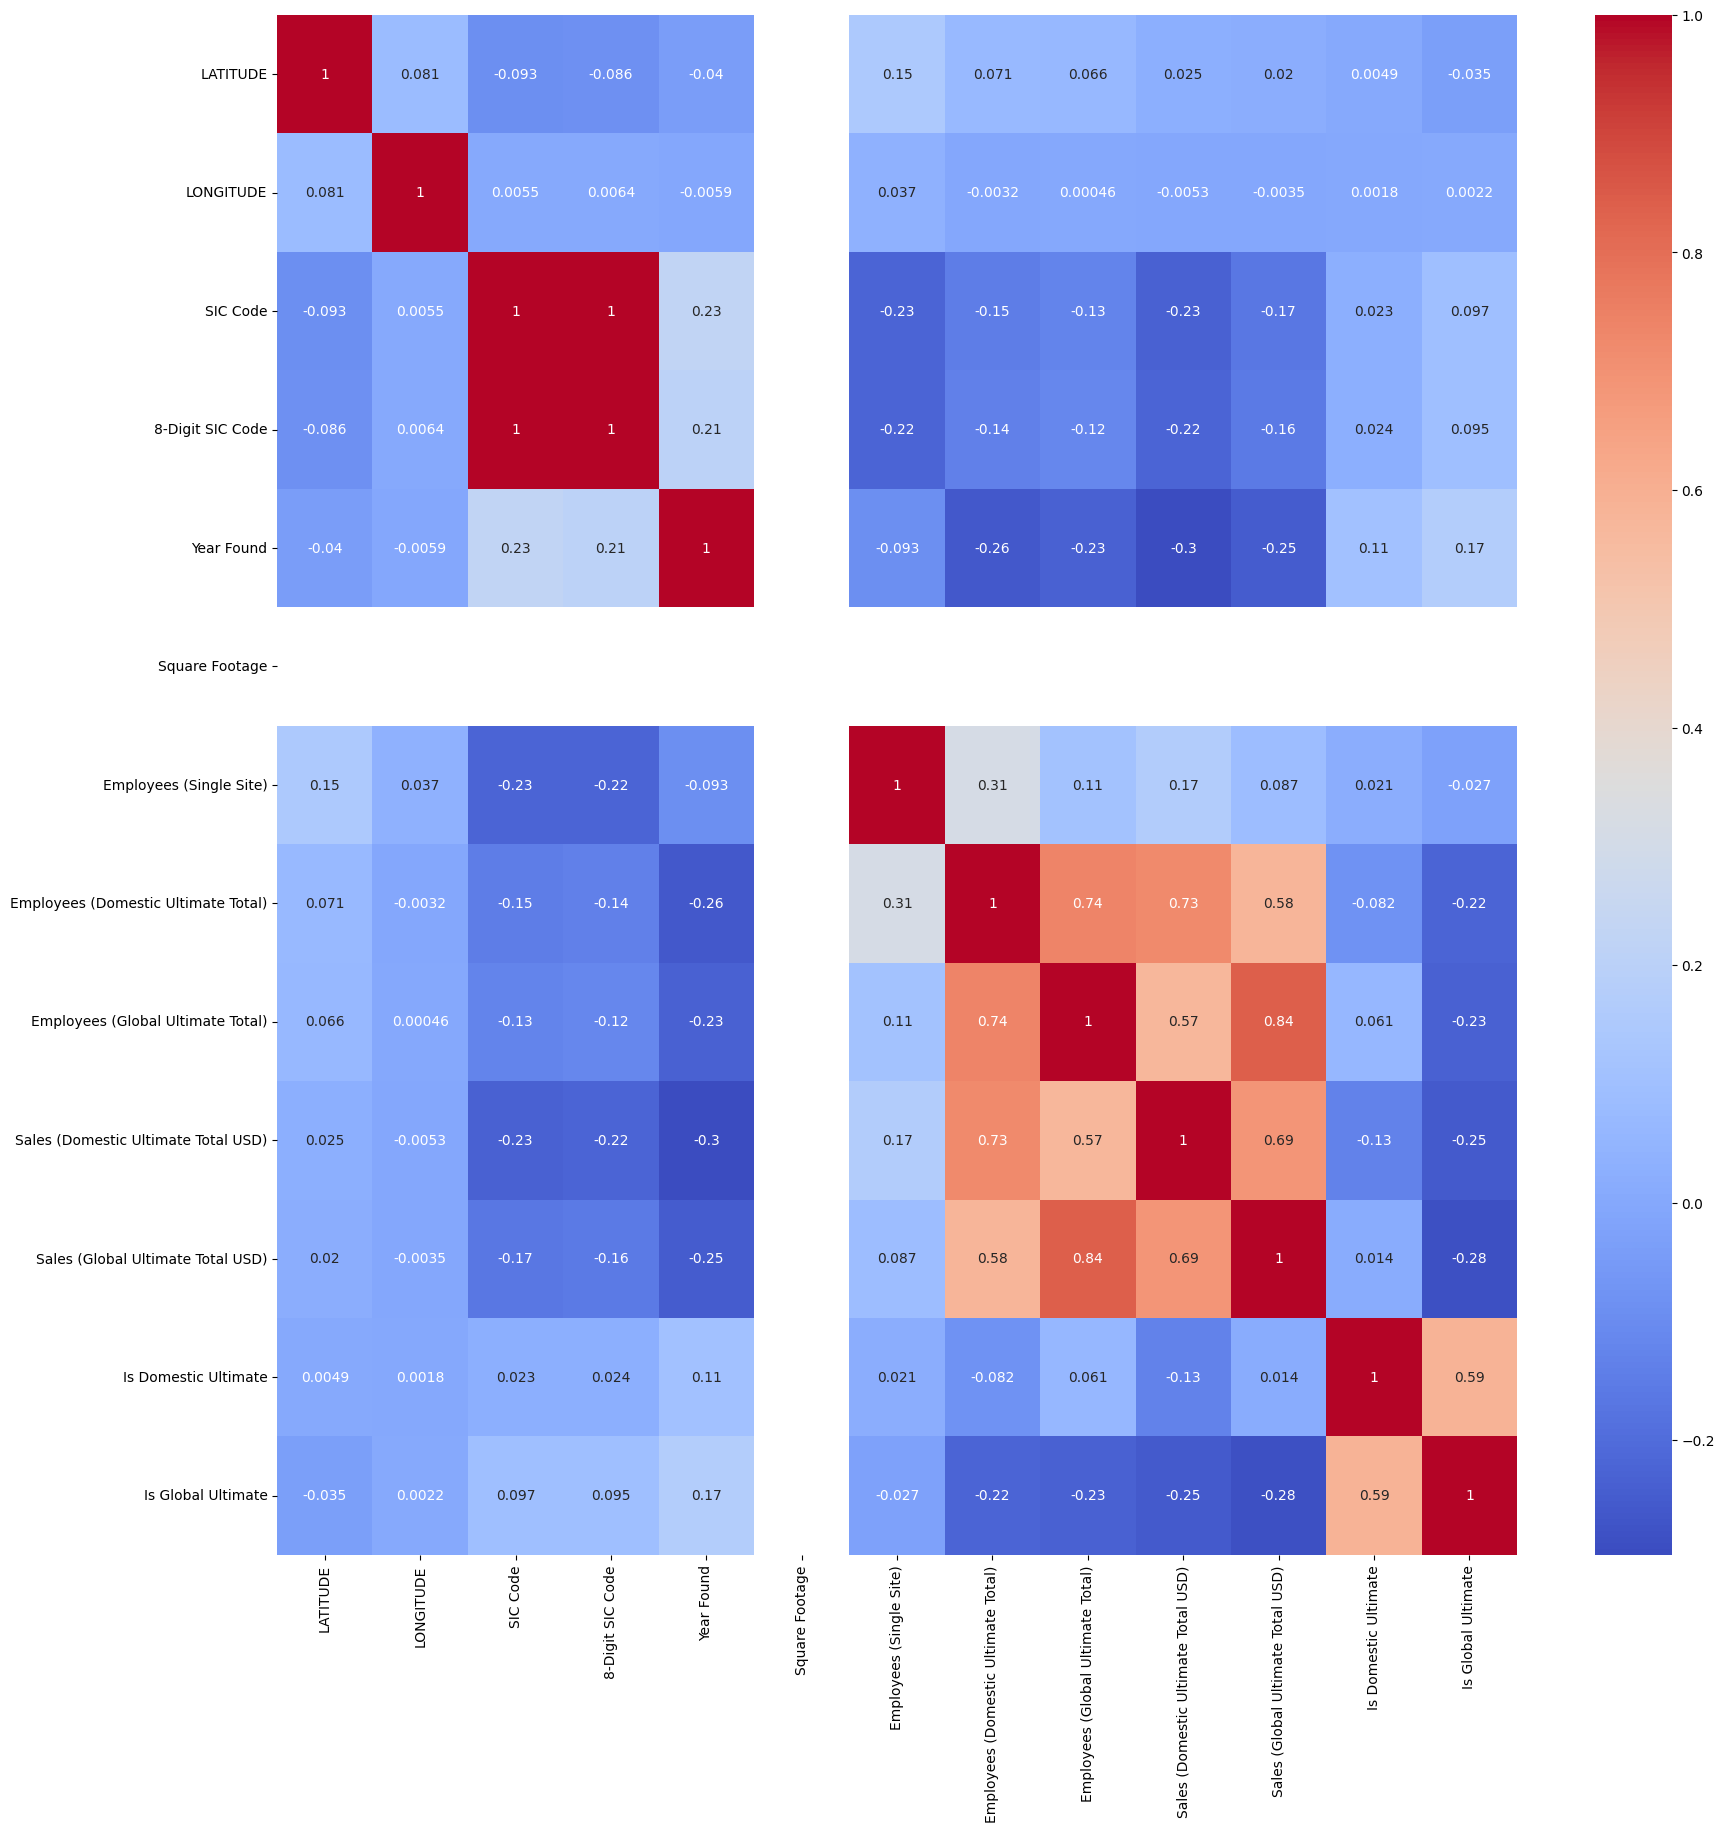

In [9]:
# Correlation Matrix 1
#build correlation matrix spearman 
#One Hot Encode Ownership Type and Entity Type to run correlation matrix
corrMatrixData = data.copy()
corrMatrixData = pd.get_dummies(corrMatrixData, columns=['Ownership Type', 'Entity Type'])

#build correlation matrix spearman 
spearman = data.corr(method='spearman')

#plot
import seaborn as sns
import matplotlib.pyplot as plt
#scale the figure size
plt.figure(figsize=(20,20))
sns.heatmap(spearman, annot=True, cmap=plt.cm.coolwarm)
plt.show()

### Correlation Matrices (Pearson)

C:\Users\seans\AppData\Local\Temp\ipykernel_25676\3268825061.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman = data.corr()


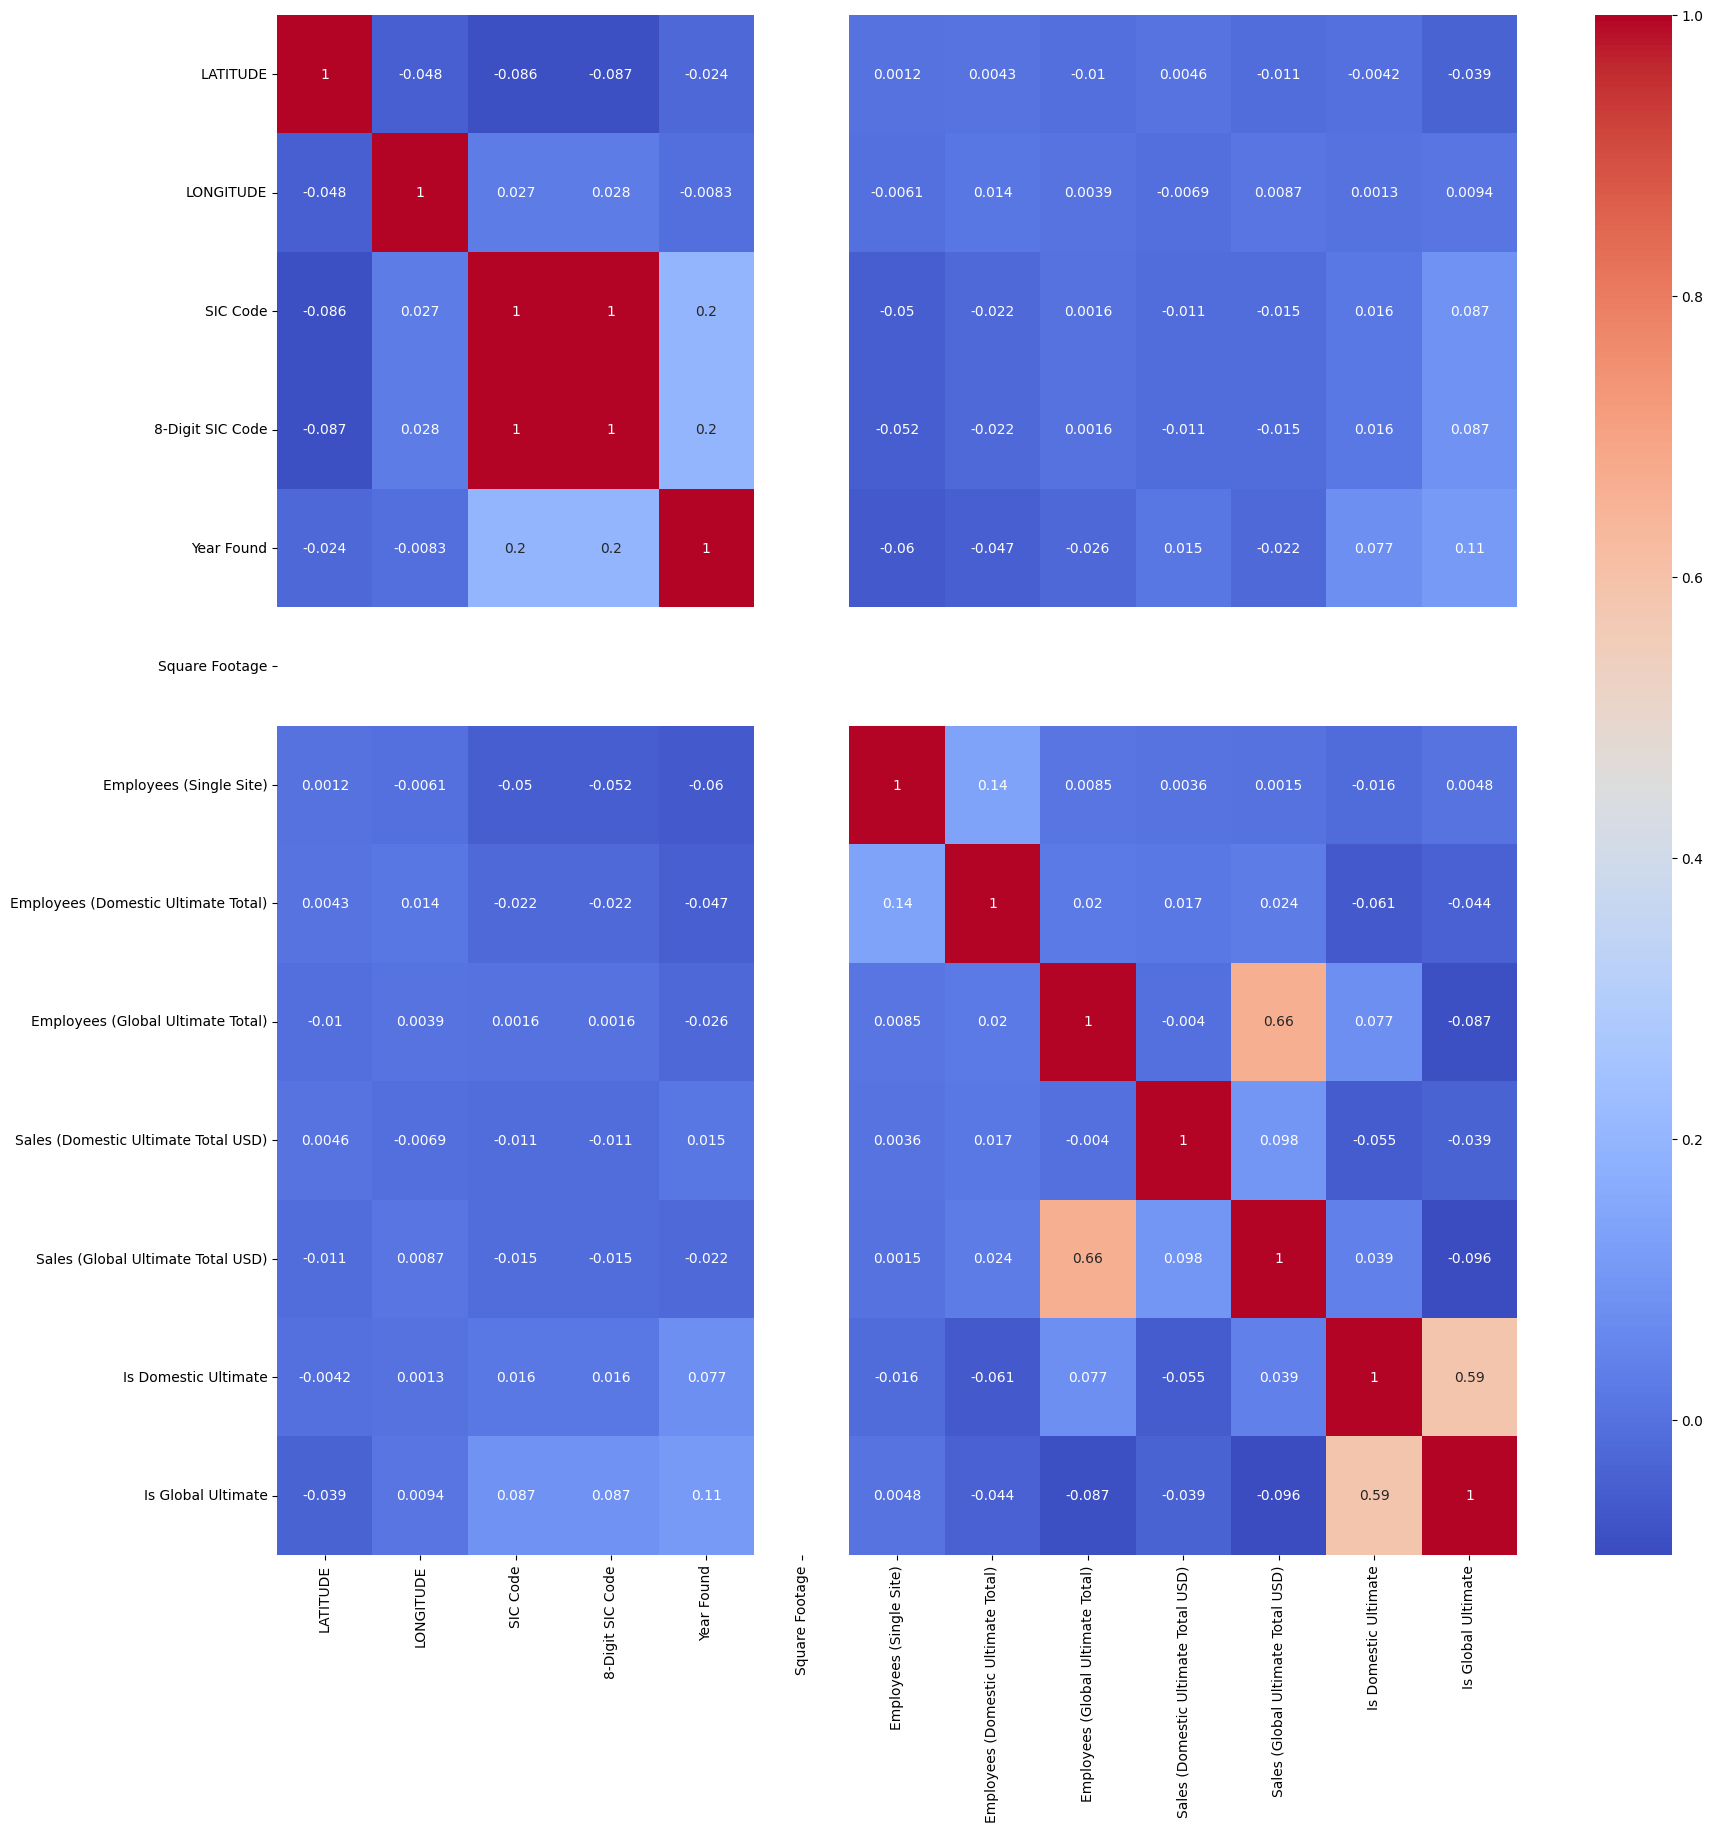

In [11]:
# Correlation Matrix 2
#build correlation matrix Pearson 
#One Hot Encode Ownership Type and Entity Type to run correlation matrix
corrMatrixData = data.copy()
corrMatrixData = pd.get_dummies(corrMatrixData, columns=['Ownership Type', 'Entity Type'])

#build correlation matrix Pearson 
spearman = data.corr()

#plot
import seaborn as sns
import matplotlib.pyplot as plt
#scale the figure size
plt.figure(figsize=(20,20))
sns.heatmap(spearman, annot=True, cmap=plt.cm.coolwarm)
plt.show()

### Other Misc Exploration

In [13]:
#Consider the case where the company is both a Domestic Ultimate and Global Ultimate (i.e no parent company)
#It goes that its global sales must be equal to its domestic sales
#Since we are given the global sales, we can "predict" the domestic sales by using the global sales
trueCount = 0
falseCount = 0
for i in range(len(data)):
    if data['Is Domestic Ultimate'][i] == data['Is Global Ultimate'][i] == 1:
        try:
            assert data['Sales (Domestic Ultimate Total USD)'][i] == data['Sales (Global Ultimate Total USD)'][i]
            trueCount += 1
        except:
            falseCount += 1

print("True count: ", trueCount)
print("False count: ", falseCount)

#Evidently, this hypothesis does not stand true for all cases

True count:  7274
False count:  233


In [14]:
#Check if any company in "Global Ultimate Company" is in "Company" except for companies which are "Is Global Ultimate" 
data[data['Global Ultimate Company'].isin(data['Company']) & (data['Is Global Ultimate'] == '0')]

,LATITUDE,LONGITUDE,AccountID,Company,SIC Code,Industry,8-Digit SIC Code,8-Digit SIC Description,Year Found,Entity Type,...,Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Fiscal Year End,Global Ultimate Company,Global Ultimate Country,Domestic Ultimate Company,Is Domestic Ultimate,Is Global Ultimate


In [15]:
#Check if any company in "Domestic Ultimate Company" is in "Company" except for companies which are "Is Domestic Ultimate" 
data[data['Domestic Ultimate Company'].isin(data['Company']) & (data['Is Domestic Ultimate'] == '0')]

,LATITUDE,LONGITUDE,AccountID,Company,SIC Code,Industry,8-Digit SIC Code,8-Digit SIC Description,Year Found,Entity Type,...,Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Fiscal Year End,Global Ultimate Company,Global Ultimate Country,Domestic Ultimate Company,Is Domestic Ultimate,Is Global Ultimate


## Part 1: Data Handling
- Data Cleaning
- Data Processing
- Handling of Null Values

### Misc Imports

In [16]:
# Import libraries
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import reverse_geocoder as rg

### Data Cleaning (Textual Data)
- Textual Data was cleaned by performing the following: Filling Null Values, Tokenisation, Removing Punctuation, Stopword and Stemming

#### Filling Null Values:
- Reason: Textual data often contains missing or null values. Filling these gaps is crucial because many natural language processing (NLP) algorithms and models require complete and consistent datasets for effective training. Imputing missing values helps avoid potential issues during analysis or modeling.

#### Tokenization:
- Reason: Tokenization is the process of breaking down text into individual units called tokens (words or subwords). This is fundamental for NLP tasks as it transforms unstructured text into a format that can be easily processed by algorithms. Tokenization is the first step in converting text data into a format suitable for analysis or modeling.

#### Removing Punctuation:
- Reason: Punctuation marks do not usually contribute much to the meaning of the text and can introduce noise in the analysis. Removing punctuation helps to standardize the text and ensures that words are processed consistently. This is especially important for tasks like sentiment analysis or text classification where the presence or absence of punctuation can impact the interpretation of the text.

#### Stopword Removal:
- Reason: Stopwords are common words (e.g., "and," "the," "is") that occur frequently but typically do not carry significant meaning. Removing stopwords can reduce the dimensionality of the data and improve the efficiency of text processing. It helps focus on the more meaningful words, improving the accuracy of NLP tasks.

#### Stemming:
- Reason: Stemming is the process of reducing words to their root or base form. It helps in consolidating variations of words to a common base form, reducing the complexity of the text data. This is beneficial for tasks like information retrieval or document clustering, where different forms of the same word should be treated as equivalent.

In summary, cleaning textual data through these processes is essential to prepare the data for analysis, machine learning, or any other NLP-related tasks. It ensures that the text is in a standardized and structured format, facilitating more accurate and efficient processing by algorithms and models.

In [31]:
#Cleans text data by filling null values, merging columns, tokenizing, removing punctuation, stopwords, and stemming.
def textCleaning(text):
    text = text.fillna('') #fill null values with empty string
    text['text'] = text.apply(lambda x: ' '.join(x), axis=1) #merge all text columns into one
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [stemmer.stem(word) for word in tokens]
        return ' '.join(tokens)

    text['text'] = text['text'].apply(clean_text)
    return text['text']    


### Data Processing (Tabular Data)
- One Hot Encoding
- Dropping Columns

#### Import/Export Status
- Import/Export Status was One Hot Encoded as follows:
- Converting "Import" to 0 or 1
- Converting "Export" to 0 or 1
- Converting both "Import/Export" to 1 and 1
  
In this way, space (columns) is saved through this "One Hot Encoding" where a traditional OneHotEncoding will occupy more space (columns)

In [18]:
#"One Hot Encode" Import/Export Status
def handleImportExport(data):
    data['Import'] = data['Import/Export Status'].apply(lambda x: 1 if x == 'Import' or x == 'Both Imports & Exports' else 0)
    data['Export'] = data['Import/Export Status'].apply(lambda x: 1 if x == 'Export' or x == 'Both Imports & Exports' else 0)
    return data.drop(['Import/Export Status'], axis=1)

#### Entity Type
- Entity Type was OneHotEncoded manually to account for other possible categories in the test data (since categorical data is not confirmed)

In [19]:
#"One Hot Encode" Entity Type (Pure One Hot Encoding)
def handleEntityType(data):
    data['Entity_Parent'] = data['Entity Type'].apply(lambda x: 1 if x == 'Parent' else 0)
    data['Entity_Subsidiary'] = data['Entity Type'].apply(lambda x: 1 if x == 'Subsidiary' else 0)
    data['Entity_Branch'] = data['Entity Type'].apply(lambda x: 1 if x == 'Branch' else 0)
    data['Entity_Independent'] = data['Entity Type'].apply(lambda x: 1 if x == 'Independent' else 0)
    data['Entity_Others'] = data['Entity Type'].apply(lambda x: 1 if x not in ['Parent', 'Subsidiary', 'Branch', 'Independent'] else 0)
    return data.drop(['Entity Type'], axis=1)

#### Dropped Columns
The following columns were dropped:
- AccountID is unique for all rows
- SIC Code is repeated in 8-Digit SIC Code
- Company is excluded since it is already repeated in Company Description
- Company Status is Active for all rows (in the dataset)
- Ownership Type has low correlation with Sales (Domestic)
- Square footage is nan for all rows
- Fiscal year end has 22445 null values (out of 29182 records). Not worth to impute values for it.

In [20]:
unusedColumns = ['AccountID', 'SIC Code', 'Company', 'Company Status (Active/Inactive)', 'Ownership Type', 'Fiscal Year End', 'Square Footage'] 

### Handling of Null Values (Imputation)
- Imputation was performed using KNN and Random Forest Regression
- While the code below does not contain model declerations, the models will be declared later on via an SKLearn Pipeline
- Imputation is done such that any missing value is the average of KNN and Random Forest Model Imputation

In [21]:
#Extract and Average imputations within the pipeline
#train ML models on existing data to predict missing values
#handling null values
def handleImputation(data):
    #split ndarray into 3 by columns
    original, imputeKNN, imputeRegressor = np.hsplit(data,3)
    #Fill null/missing values in original with the average of the imputations.
    original = np.where(np.isnan(original), ((imputeKNN + imputeRegressor) / 2).astype(int), original)
    return original

## Part 2: EDA and Feature Engineering

### Missing Value Visualisation

<AxesSubplot: >

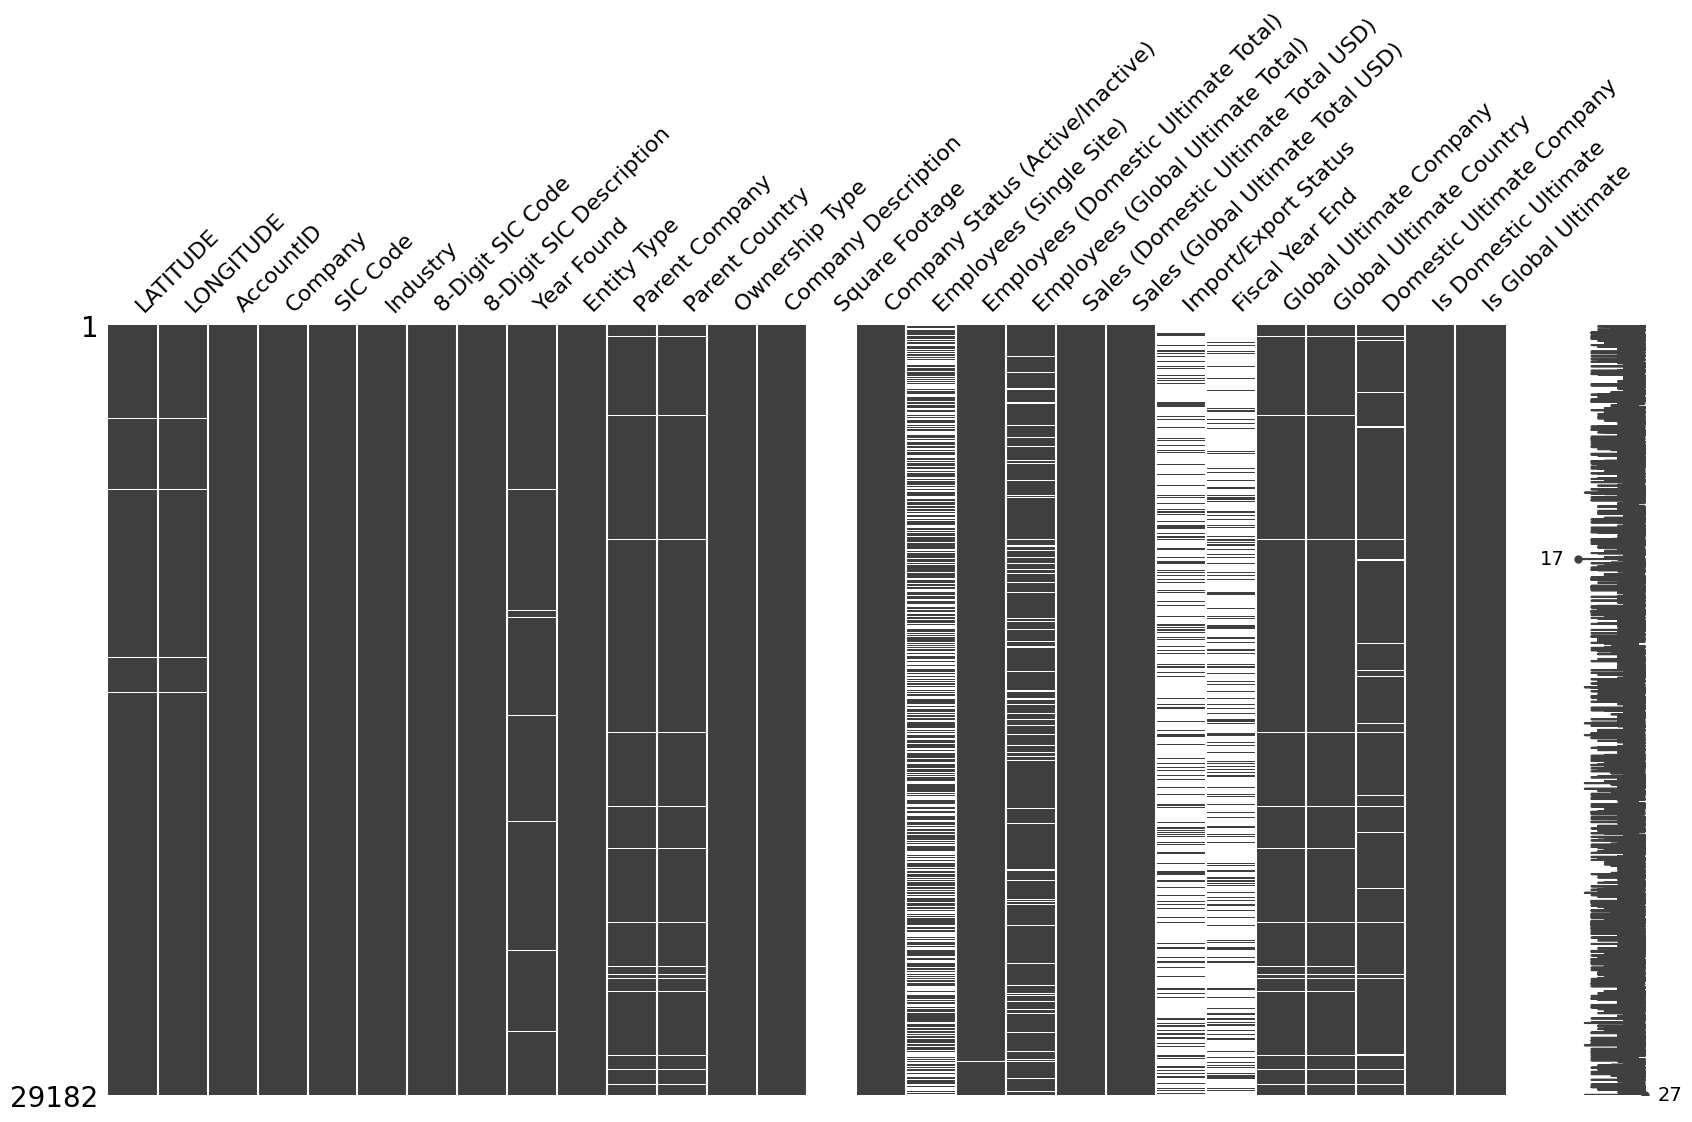

In [24]:
import missingno as msno
msno.matrix(data, figsize=(20,10))

### GeoSpatial Analysis 
- Based on the plot, it is possible for shops to be mapped

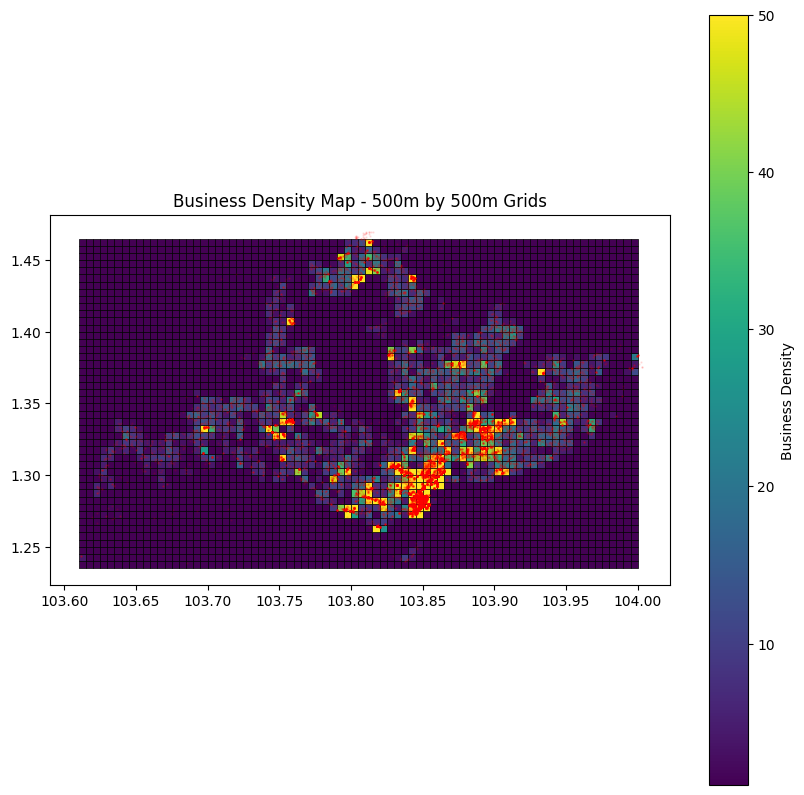

In [23]:
# Geospatial analysis (Business Density Chart)
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Step 1: Load Data and Remove Records with Null Values
df = pd.read_csv('catA_train.csv')  # Change the file name here
df = df.dropna(subset=['LONGITUDE', 'LATITUDE'])  # Remove records with null values

# Step 2: Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Check if there are any records left after removing null values
if gdf.empty:
    print("No valid records remaining after removing null values.")
else:
    # Step 3: Create a 500m by 500m grid and Find Business Density
    grid_size = 0.005  # 500m by 500m grid size

    # Create a bounding box for the grid
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    x_grid = [i for i in range(int(minx / grid_size) * int(grid_size * 1000), int(maxx / grid_size) * int(grid_size * 1000) + int(grid_size * 1000), int(grid_size * 1000))]
    y_grid = [i for i in range(int(miny / grid_size) * int(grid_size * 1000), int(maxy / grid_size) * int(grid_size * 1000) + int(grid_size * 1000), int(grid_size * 1000))]

    # Create a GeoDataFrame for the grid
    polygons = []
    for x in range(len(x_grid)-1):
        for y in range(len(y_grid)-1):
            polygons.append(Polygon([(x_grid[x]/1000, y_grid[y]/1000), (x_grid[x+1]/1000, y_grid[y]/1000), (x_grid[x+1]/1000, y_grid[y+1]/1000), (x_grid[x]/1000, y_grid[y+1]/1000)]))
    grid = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:4326')

    # Iterate over each grid and calculate business density
    business_density = []
    for index, grid_cell in grid.iterrows():
        intersected_businesses = gdf[gdf.geometry.intersects(grid_cell.geometry)]
        business_density.append(len(intersected_businesses))

    # Add the business density information to the grid GeoDataFrame
    grid['Business_Density'] = business_density

    # Step 4: Visualize the grid density
    fig, ax = plt.subplots(figsize=(10, 10))
    grid.plot(ax=ax, column='Business_Density', cmap='viridis', legend=True, legend_kwds={'label': "Business Density"}, edgecolor='black', linewidth=0.5, vmin=1, vmax=50)
    gdf.plot(ax=ax, markersize=0.5, color='red', alpha=0.1)
    plt.title('Business Density Map - 500m by 500m Grids')
    plt.show()

### Grid Density Feature (Fail)
- Based on the above plot, it is possible for a feature to be created: `Grid Density`, measuring the density of businesses within a specified grid where the company is located
- It is theorised that this Feature is highly correlated with Sales (Domestic)
- This feature had a low correlation and thus is labelled as "Fail" and unused

In [25]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# Step 1: Load Data and Remove Records with Null Values
df = data 
df = df.dropna(subset=['LONGITUDE', 'LATITUDE'])  # Remove records with null values

# Step 2: Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Check if there are any records left after removing null values
if gdf.empty:
    print("No valid records remaining after removing null values.")
else:
    # Step 3: Create a 500m by 500m grid and Find Business Density
    grid_size = 0.005  # 500m by 500m grid size

    # Create a bounding box for the grid
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    x_grid = [i for i in range(int(minx / grid_size) * int(grid_size * 1000), int(maxx / grid_size) * int(grid_size * 1000) + int(grid_size * 1000), int(grid_size * 1000))]
    y_grid = [i for i in range(int(miny / grid_size) * int(grid_size * 1000), int(maxy / grid_size) * int(grid_size * 1000) + int(grid_size * 1000), int(grid_size * 1000))]

    # Create a GeoDataFrame for the grid
    polygons = []
    for x in range(len(x_grid)-1):
        for y in range(len(y_grid)-1):
            polygons.append(Polygon([(x_grid[x]/1000, y_grid[y]/1000), (x_grid[x+1]/1000, y_grid[y]/1000), (x_grid[x+1]/1000, y_grid[y+1]/1000), (x_grid[x]/1000, y_grid[y+1]/1000)]))
    grid = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:4326')

    # Iterate over each grid and calculate business density
    business_density = []
    for index, grid_cell in grid.iterrows():
        intersected_businesses = gdf[gdf.geometry.intersects(grid_cell.geometry)]
        business_density.append(len(intersected_businesses))

    # Add the business density information to the grid GeoDataFrame
    grid['Business_Density'] = business_density

    # Step 4: Create a new column in the original dataframe with business density values
    gdf['Grid_Business_Density'] = gdf['geometry'].apply(lambda x: grid.loc[grid.geometry.intersects(x)].iloc[0]['Business_Density'] if not grid.loc[grid.geometry.intersects(x)].empty else None)

    # Step 5: Display the new dataframe with the added column
    print(gdf[['LONGITUDE', 'LATITUDE', 'Grid_Business_Density']])

        LONGITUDE  LATITUDE  Grid_Business_Density
0      103.843852  1.285495                  251.0
1      103.827476  1.291294                   40.0
2      103.857517  1.300144                  132.0
3      103.791263  1.300785                   39.0
4      103.859430  1.298759                  627.0
...           ...       ...                    ...
29177  103.887857  1.355309                   41.0
29178  103.898298  1.319605                   43.0
29179  103.924303  1.316363                   10.0
29180  103.858968  1.295595                  627.0
29181  103.801710  1.311769                    8.0

[29062 rows x 3 columns]


In [29]:
#Run correlation matrix for gdf Grid Business Density and Sales Domestic Ultimate Total USD
#build correlation matrix Pearson and display correlation for Grid Business Density and Sales Domestic Ultimate Total USD
pearson = gdf.corr()
print("Pearson Correlation: ")
print(pearson['Sales (Domestic Ultimate Total USD)']['Grid_Business_Density'])

Pearson Correlation: 
0.0016391308207503248


C:\Users\seans\AppData\Local\Temp\ipykernel_25676\2007840473.py:3: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson = gdf.corr()


In [30]:
#Run correlation matrix for gdf Grid Business Density and Sales Domestic Ultimate Total USD
#build correlation matrix Pearson and display correlation for Grid Business Density and Sales Domestic Ultimate Total USD
spearman = gdf.corr(method='spearman')
print("Spearman Correlation: ")
print(spearman['Sales (Domestic Ultimate Total USD)']['Grid_Business_Density'])

Spearman Correlation: 
-0.035720020419258355


C:\Users\seans\AppData\Local\Temp\ipykernel_25676\3427126731.py:3: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman = gdf.corr(method='spearman')


### Feature Engineering of Coordinates (Fail)
- An Attempt to Convert Coordinates into Locational Data (City, Administrative Area, Suburb, etc)

#### Rationale For Not Using GeoLocation
1) Reverse geolocation lookup consists of either an Internet Lookup or an Offline Lookup via a Multi-threaded K-D Tree. 
2) Consider Internet Lookup (ONLINE), unfeasible to lookup all records and will likely get ratelimited or IP blocked
3) Consider Multi-threaded K-D tree (OFFLINE), extremely Compute Intensive and Memory Intensive. Will drastically affect train and prediction time


In [ ]:
def handleGeoDataOffline(data):
    data['GeoData'] = ''
    # Perform vectorized reverse geocoding using apply
    def reverse_geocode(row):
        try:
            result = rg.search((row['LATITUDE'], row['LONGITUDE']))
            return result[0]['name'] + ' ' + result[0]['admin1'] + ' ' + result[0]['admin2']
        except:
            return ''
    data['GeoData'] = data.apply(reverse_geocode, axis=1)
    return data.drop(['LATITUDE', 'LONGITUDE'], axis=1)

In [ ]:
def handleGeoDataOnline(data):
    geolocator = Nominatim(user_agent="geoapiExercises")
    def getGeoData(lat, long):
        if np.isnan(lat) or np.isnan(long):
            return ''
        else:
            try:
                loc = geolocator.reverse((lat, long))
                output = loc.raw['address'].get('city', ' ')
                output += ' ' + loc.raw['address'].get('state', ' ')
                output += ' ' + loc.raw['address'].get('country', ' ')
                output += ' ' + loc.raw['address'].get('suburb', ' ')
                output += ' ' + loc.raw['address'].get('quarter', ' ')
                output += ' ' + loc.raw['address'].get('building', ' ')
                return output
            except:
                return ''
    #attempt to extract geodata from lat and long using geopy. If no lat and long, return empty string
    data["GeoData"] = data.apply(lambda x: getGeoData(x['LATITUDE'], x['LONGITUDE']), axis=1)
    return data.drop(['LATITUDE', 'LONGITUDE'], axis=1)    

### Business life cycle based on SIC (Fail)
- It is highly likely that a Company's Age (derived from Year Found) is correlated with its business life cycle stage. 
- It is also expected that a Startup may perform better than a company in decline, or a mature company may perform better than a Startup company simply due to the resources at hand and volume of sales/customer/revenue
- While it is possible to categorise records based on a generalised assumption, it is instead likely that different idustries (SIC Code) will have different definitions/conditions to classify companies as either Startup/Growth/Mature/Decline/
- While the code is not included, this feature was **not used** due to its extremely low correlation of `0.0001`

### Natural Language Processing (USED)
- Given the low correlation observed in Tabular Data, we attempted to make use of Natural Language Processing.
- Specifically, we decided to make use of TF-IDF
- BagOfWords and CountVectorisation were initially tested and used, but ditched in favour of TF-IDF which is superior to BagOfWords, Dictionary/Frequency Tables/Count Vectorisation

#### Term Frequency Inverse Document Frequency (TF-IDF)
A key component of natural language processing (NLP) is TF-IDF (Term Frequency-Inverse Document Frequency),
which gauges a word's importance inside a document in relation to a larger collection. It combines inverse 
document frequency, which measures how unique a word is across a collection, with term frequency, which 
measures how frequently a word appears in a document. This produces a score that minimises common words 
and emphasises significant terms found in a document. TF-IDF is extensively employed in tasks including 
text summarization, machine learning applications, keyword extraction, document retrieval, and content 
summaries because it facilitates the language-independent extraction of the essential information and the 
prioritisation of pertinent data.

In [32]:
textPipeline = Pipeline([
    ('textCleaning', FunctionTransformer(textCleaning)),
    ('vectorizer', TfidfVectorizer()) #access importance of words in the data through term frequency, inverse document frequency
])

## Part 3: Model Selection
- We first ran a script to brute force the best possible model suitable for our data.
- Notably, Linear Regression, SVR and Ridge Regressors were unsuitable and timed out. This is likely due to the fact that with TF-IDF Vectorisation, regression making use of gradient descent or other optimisation algorithms becomes computationally expensive and inefficient. 
- It is also unsurprising that the top performing models are derivatives of Decision Trees which do not rely on computing the partial derivative of the entire dataset. These models are more efficient (time and space complexity)
- With the highest model tested being **BaggingRegressor**, we decided to make use of it. BaggingRegressor is not only the highest performing model, it is also able to handle our extremely large dataset and suitable for NLP tasks.


### Brute Force Script
- SVR, Linear Regression and Ridge regression removed as it is not suitable to run against NLP (high time complexity given large number of features from tfidf)
- PoissonRegressor removed as it is not suitable for negative values
- LassoLarsIC removed as the number of samples is smaller than the number of features (due to tfidf)
- Gamma Regressor removed as values are out of range/not according to assumed distribution

In [34]:
# Brute forcing the best training model
from pebble import ProcessPool
from concurrent.futures import TimeoutError
from multiprocessing import freeze_support
import sys

import traceback
import timeit
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LassoLarsIC, GammaRegressor, TweedieRegressor, BayesianRidge, ARDRegression,  LinearRegression, Ridge, RidgeCV, SGDRegressor, ElasticNet, HuberRegressor, QuantileRegressor, RANSACRegressor, TheilSenRegressor, PoissonRegressor, PassiveAggressiveRegressor, OrthogonalMatchingPursuit
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression, PLSCanonical

def format_time(seconds):
    return time.strftime('%H:%M:%S', time.gmtime(seconds))

def initializer(limit):
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (limit, hard))

'''
SVR, Linear Regression and Ridge regression removed as it is not suitable to run against NLP (high time complexity given large number of features from tfidf)
PoissonRegressor removed as it is not suitable for negative values
LassoLarsIC removed as the number of samples is smaller than the number of features (due to tfidf)
Gamma Regressor removed as values are out of range/not according to assumed distribution
'''
regressors = {
    "AdaBoost (square)" : AdaBoostRegressor(random_state=2024, n_estimators=10, loss="square"),
    "AdaBoost (linear)" : AdaBoostRegressor(random_state=2024, n_estimators=10, loss="linear"),
    "Adaboost (exponential)" : AdaBoostRegressor(random_state=2024, n_estimators=10, loss="exponential"),
    "Bagging" : BaggingRegressor(n_estimators=10, random_state=2024),
    #"Bagging (svr)": BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=2024),
    "ExtraTrees (abs err)" : ExtraTreesRegressor(criterion = "absolute_error", n_estimators=10, random_state=2024),
    "ExtraTrees (sq err)" : ExtraTreesRegressor(criterion = "squared_error", n_estimators=10, random_state=2024),
    "GradientBoosting (huber)" : GradientBoostingRegressor(random_state=2024,loss="huber"),
    "GradientBoosting (sq err)" : GradientBoostingRegressor(random_state=2024,loss="squared_error"),
    "GradientBoosting (abs err)" : GradientBoostingRegressor(random_state=2024,loss="absolute_error"),
    "Random Forest (sq err)" : RandomForestRegressor(max_depth=2, random_state=2024,criterion="squared_error"),
    "Random Forst (abs err)" : RandomForestRegressor(max_depth=2, random_state=2024,criterion="absolute_error"),
    #"Random Forest (poisson)" : RandomForestRegressor(max_depth=2, random_state=2024,criterion="poisson"),
    "HistGradientBoosting (sq err)" : HistGradientBoostingRegressor(loss="squared_error"),
    "HistGradientBoosting (abs err)" : HistGradientBoostingRegressor(loss="absolute_error"),
    #"HistGradientBoosting (poisson)" : HistGradientBoostingRegressor(loss="poisson"),
    "GaussianProcess" : GaussianProcessRegressor(random_state=2024),
    #"Linear" : LinearRegression(),
    #"Ridge (Linear)" : Ridge(),
    #"RidgeCV" : RidgeCV(),
    "SGDRegressor (elasticnet)" : make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3,penalty="elasticnet")),
    "SGDRegressor (l2)" : make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3,penalty="l2")),
    "SGDRegressor (l1)" : make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3,penalty="l1")),
    "Elastic Net (random)" : ElasticNet(random_state=2024,selection="random"),
    "Elastic Net (cyclic)" : ElasticNet(random_state=2024,selection="cyclic"),
    "ARD" : ARDRegression(),
    "BayesianRidge" : BayesianRidge(),
    "Huber" : HuberRegressor(),
    "Quantile (highs-ds)" : QuantileRegressor(quantile=0.8, solver="highs-ds"),
    "Quantile (highs-ipm)" : QuantileRegressor(quantile=0.8, solver="highs-ipm"),
    "Quantile (highs)" : QuantileRegressor(quantile=0.8, solver="highs"),
    "Quantile (interior-point)" : QuantileRegressor(quantile=0.8, solver="interior-point"),
    "Quantile (revised simplex)" : QuantileRegressor(quantile=0.8, solver="revised simplex"),
    "RANSAC": RANSACRegressor(random_state=2024, min_samples=0.5),
    "TheilSenRegressor" : TheilSenRegressor(random_state=2024),
    #"PoissonRegressor" : PoissonRegressor(),
    "TweedieRegressor (auto)" : TweedieRegressor(link="auto"),
    "TweedieRegressor (identity)" : TweedieRegressor(link="identity"),
    "TweedieRegressor (log)" : TweedieRegressor(link="log"),
    #"GammaRegressor" : GammaRegressor(),
    "PassiveAggressiveRegressor (epsilon_insensitive)" :  PassiveAggressiveRegressor(max_iter=100, random_state=2024, tol=1e-3, loss="epsilon_insensitive"),
    "PassiveAggressiveRegressor (squared_epsilon_insensitive)" :  PassiveAggressiveRegressor(max_iter=100, random_state=2024, tol=1e-3, loss="squared_epsilon_insensitive"),
    "KNeighbors" : KNeighborsRegressor(n_neighbors=3),
    "Radius Neighbors" : RadiusNeighborsRegressor(radius=1.0),
    "MLP" : MLPRegressor(random_state=2024, max_iter=500),
    "DecisionTree" : DecisionTreeRegressor(random_state=2024),
    "Extra Tree" : ExtraTreeRegressor(random_state=2024),
    #"Kernel Ridge" : KernelRidge(alpha=1.0),
    #"Linear SVR (epsilon_insensitive)" : make_pipeline(StandardScaler(), LinearSVR(random_state=2024, tol=1e-5, loss="epsilon_insensitive")),
    #"Linear SVR (squared_epsilon_insensitive)" : make_pipeline(StandardScaler(), LinearSVR(random_state=2024, tol=1e-5, loss="squared_epsilon_insensitive")),
    #"nuSVR" : make_pipeline(StandardScaler(), NuSVR(C=1.0, nu=0.1)),
    #"SVR" : make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)),
    #"LassoLarsIC (bic)" : LassoLarsIC(criterion='bic'),
    #"LassoLarsIC (aic)" : LassoLarsIC(criterion='aic'),
    "PLS" : PLSRegression(n_components=2),
    "OrthogonalMatchingPursuit" : OrthogonalMatchingPursuit(),
    "PLSCanonical" : PLSCanonical(n_components=1)
}

def test_regressor(regressor_type, X_train, X_test, y_train, y_test): 
    try:
        start_time = timeit.default_timer()
        print("\nRegressor", regressor_type, "...")
        reg = regressors[regressor_type]
        reg.fit(X_train, y_train)
        y_predicted = reg.predict(X_test)
        accuracy = metrics.r2_score(y_test, y_predicted)
        print("\nRegressor", regressor_type, "r^2 is", accuracy)
        stop_time = timeit.default_timer()
        print("Regressor", regressor_type, "completed in", format_time(stop_time-start_time))
        return [regressor_type, accuracy]
    except Exception: 
        print("\nError for Regressor", regressor_type)
        traceback.print_exc()

def test_regressors(X_train, X_test, y_train, y_test):
    result_queue = []
    if (LINUX):
        with ProcessPool(max_workers=POOL,initializer=initializer, initargs=(MAX_MEMORY,)) as pool:             
            multiple_results = [(pool.schedule(test_regressor, args=(key, X_train, X_test, y_train, y_test), timeout=TIMEOUT_SECONDS), key) for key in regressors]
            for res in multiple_results:
                try:
                    tmp = res[0].result()
                    if tmp is not None:
                        result_queue.append(tmp)
                except TimeoutError:
                    print("\nClassifier", res[1], "exceeded the time limit.")
                except MemoryError:
                    print("\nClassifier", res[1], "exceeded the memory limit.")
                except Exception:
                    print("\nClassifier", res[1], "experienced an error.")
                except:
                    print("\nClassifier", res[1], "experienced an error.")

    else: 
        with ProcessPool(max_workers=POOL) as pool:             
            multiple_results = [(pool.schedule(test_regressor, args=(key, X_train, X_test, y_train, y_test), timeout=TIMEOUT_SECONDS), key) for key in regressors]
            for res in multiple_results:
                try:
                    tmp = res[0].result()
                    if tmp is not None:
                        result_queue.append(tmp)
                except TimeoutError:
                    print("\nClassifier", res[1], "exceeded the time limit.") 
                except Exception:
                    print("\nClassifier", res[1], "experienced an error.")

    r2 = {}
    for value in result_queue:
        r2[value[0]] = value[1]
    r2 = {k: v for k, v in sorted(r2.items(), key=lambda item: item[1], reverse=True)}

    print("Results r^2: \n")
    untested = set(regressors.keys())
    i = 1
    for key in r2:
        print(i, key, r2[key])
        untested.remove(key)
        i += 1
    print("\nUntested Regressors:", untested)

if __name__ == "__main__":
    TIMEOUT_SECONDS = 60 * 10
    POOL = 4
    MAX_MEMORY = 10737418240 * 3 #in bytes
    SILENT = False

    if ("win" in sys.platform):
        print("Windows Detected")
        freeze_support()
        LINUX = False
    else: 
        print("Linux Assumed:")
        import resource
        LINUX = True
    if SILENT:
        import warnings
        warnings.filterwarnings("ignore")

    #import X_train, X_test, y_train, y_test pickle
    import pickle
    X_train = pd.read_pickle("X_train.pkl")
    X_test = pd.read_pickle("X_test.pkl")
    y_train = pd.read_pickle("y_train.pkl")
    y_test = pd.read_pickle("y_test.pkl")
    test_regressors(X_train, X_test, y_train, y_test)

Windows Detected


FileNotFoundError: [Errno 2] No such file or directory: 'X_train.pkl'

### Output for Brute Force Script
```python
Results r^2:

1 Bagging 0.9852704006369875
2 ExtraTrees (sq err) 0.9847644247937739
3 GradientBoosting (sq err) 0.983382900269856
4 Extra Tree 0.9786768872375041
5 Adaboost (exponential) 0.9621678988851213
6 DecisionTree 0.9614951125955862
7 Random Forest (sq err) 0.958290096961832
8 AdaBoost (square) 0.9470516826313927
9 AdaBoost (linear) 0.9398776549182355
10 GradientBoosting (huber) 0.8188006325634624
11 KNeighbors 0.18033795111550877
12 MLP 0.010260148709562822
13 TweedieRegressor (auto) 0.0099788428790486
14 TweedieRegressor (identity) 0.0099788428790486
15 RANSAC 0.00833990157486475
16 TweedieRegressor (log) -3.986875471762019e-05
17 GradientBoosting (abs err) -0.0013817071427502103
18 Quantile (highs-ds) -0.004041198033066573
19 Quantile (highs-ipm) -0.004041198033066573
20 Quantile (highs) -0.004041198033066573
21 Huber -0.005534718021654728
22 PassiveAggressiveRegressor (epsilon_insensitive) -0.021593538957859204
23 PassiveAggressiveRegressor (squared_epsilon_insensitive) -0.021593538957859204

Untested Regressors: {'ARD', 'PLS', 'Elastic Net (cyclic)', 'SGDRegressor (elasticnet)', 'SGDRegressor (l1)', 'HistGradientBoosting (sq err)', 'OrthogonalMatchingPursuit', 'ExtraTrees (abs err)', 'BayesianRidge', 'Quantile (revised simplex)', 'GaussianProcess', 'TheilSenRegressor', 'PLSCanonical', 'Random Forst (abs err)', 'Quantile (interior-point)', 'SGDRegressor (l2)', 'Radius Neighbors', 'HistGradientBoosting (abs err)', 'Elastic Net (random)'}
```

## Part 3.5: Pipeline Decleration
- Define Pipeline used to process data and feature engineer

In [35]:
def dropColumns(data, columns):
    return data.drop(columns, axis=1)

def copy(data):
    return data

#"One Hot Encode" Import/Export Status
def handleImportExport(data):
    data['Import'] = data['Import/Export Status'].apply(lambda x: 1 if x == 'Import' or x == 'Both Imports & Exports' else 0)
    data['Export'] = data['Import/Export Status'].apply(lambda x: 1 if x == 'Export' or x == 'Both Imports & Exports' else 0)
    return data.drop(['Import/Export Status'], axis=1)

#"One Hot Encode" Entity Type
def handleEntityType(data):
    data['Entity_Parent'] = data['Entity Type'].apply(lambda x: 1 if x == 'Parent' else 0)
    data['Entity_Subsidiary'] = data['Entity Type'].apply(lambda x: 1 if x == 'Subsidiary' else 0)
    data['Entity_Branch'] = data['Entity Type'].apply(lambda x: 1 if x == 'Branch' else 0)
    data['Entity_Independent'] = data['Entity Type'].apply(lambda x: 1 if x == 'Independent' else 0)
    data['Entity_Others'] = data['Entity Type'].apply(lambda x: 1 if x not in ['Parent', 'Subsidiary', 'Branch', 'Independent'] else 0)
    return data.drop(['Entity Type'], axis=1)

#Extract and Average imputations within the pipeline
def handleImputation(data):
    #split ndarray into 3 by columns
    original, imputeKNN, imputeRegressor = np.hsplit(data,3)
    #Fill null/missing values in original with the average of the imputations.
    original = np.where(np.isnan(original), ((imputeKNN + imputeRegressor) / 2).astype(int), original)
    return original

#Cleans text data by filling null values, merging columns, tokenizing, removing punctuation, stopwords, and stemming.
def textCleaning(text):
    text = text.fillna('') 
    text['text'] = text.apply(lambda x: ' '.join(x), axis=1) 
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [stemmer.stem(word) for word in tokens]
        return ' '.join(tokens)

    text['text'] = text['text'].apply(clean_text)
    return text['text']    

tabularPipeline = Pipeline([
    ('handleImportExport', FunctionTransformer(handleImportExport)),
    ('handleEntityType', FunctionTransformer(handleEntityType)),
    ('imputeCombined' , FeatureUnion([
        ('copyTabular', FunctionTransformer(copy)),
        ('imputeKNN', KNNImputer(n_neighbors=5)),
        ('imputeRegressor', IterativeImputer(RandomForestRegressor(), max_iter=100, random_state=2024))
    ])),
    ('imputeAverage', FunctionTransformer(handleImputation)),
])

textPipeline = Pipeline([
    ('textCleaning', FunctionTransformer(textCleaning)),
    ('vectorizer', TfidfVectorizer())
])

geoColumns = ['LATITUDE', 'LONGITUDE']
textualColumns = ['Company Description', 'Industry', '8-Digit SIC Description', 'Parent Company', 'Parent Country', 'Global Ultimate Company', 'Global Ultimate Country' ,'Domestic Ultimate Company']
tabularColumns = ['8-Digit SIC Code', 'Year Found', 'Entity Type', 'Employees (Single Site)', 'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)', 'Sales (Global Ultimate Total USD)', 'Import/Export Status', 'Is Domestic Ultimate', 'Is Global Ultimate']
unusedColumns = ['AccountID', 'SIC Code', 'Company', 'Company Status (Active/Inactive)', 'Ownership Type', 'Fiscal Year End', 'Square Footage'] 

processData = Pipeline([
    ('dropColumns', FunctionTransformer(dropColumns, kw_args={'columns': unusedColumns + geoColumns})),
    ('transformer', ColumnTransformer([
        ('tabularPipeline', tabularPipeline, tabularColumns),
        ('textPipeline', textPipeline, textualColumns)
    ])),
])

## Part 4: Model Training
- BaggingRegressor was trained using an 80-20 split (20% of data used for testing).
- To **Handle Imbalance**, we made use of stratified sampling in our `train_test_split` instead of K-Fold Validation (which does not support stratified sampling)
- This prevents the following situation from occurring. Consider the case where records belonging to the minority class of Entity Type is a complete subset of Training data. The testing data will thus not include any records belonging to the minority class and there will be no way to test the model with relation to its ability to predict records belonging to the minority class. 

In [37]:
data = pd.read_csv('catA_train.csv')
X = data.drop(['Sales (Domestic Ultimate Total USD)'], axis=1)
y = data['Sales (Domestic Ultimate Total USD)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7777, stratify=X['Entity Type']) #IMPT. K-Fold does not allow for stratified sampling. HANDLING IMBALANCE

# TRAINING
X_train = processData.fit_transform(X_train)
model = BaggingRegressor(n_estimators=10, random_state=7777, verbose=10)
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


BaggingRegressor(random_state=7777, verbose=10)

## Part 5: Model Evaluation
- The model was evaluated using r^2 value and adjusted r^2

## FINAL MODEL STATS
From our model, we managed to obtain an **R-squared value of `0.9826345534247569`** and **Adjusted R-squared value of `0.9376548847795069`** which is an indication that the model is accurate in predicting the actual value.

In [38]:
X_test = processData.transform(X_test)
y_pred = model.predict(X_test)
from sklearn.metrics import r2_score
print("r^2: ", r2_score(y_test, y_pred))
print("adj r^2: ", 1 - (1-r2_score(y_test, y_pred)) * (len(y)-1)/(len(y)-X_test.shape[1]-1))

r^2:  0.9826345534247569
adj r^2:  0.9376548847795069


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


## Dependencies Required!
- pandas
- numpy
- ntlk
- reverse_geocoder `pip install reverse_geocoder`

## System Requirements
The model has been trained and run sucessfully with **16GB Ram** and an **i7 CPU**

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [1]:
#Imports
import pandas as pd
import numpy as np
import string
import nltk
import reverse_geocoder as rg
import joblib
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#Include Functions used in Pipeline
def dropColumns(data, columns):
    return data.drop(columns, axis=1)

def copy(data):
    return data

#"One Hot Encode" Import/Export Status
def handleImportExport(data):
    data['Import'] = data['Import/Export Status'].apply(lambda x: 1 if x == 'Import' or x == 'Both Imports & Exports' else 0)
    data['Export'] = data['Import/Export Status'].apply(lambda x: 1 if x == 'Export' or x == 'Both Imports & Exports' else 0)
    return data.drop(['Import/Export Status'], axis=1)

#"One Hot Encode" Entity Type
def handleEntityType(data):
    data['Entity_Parent'] = data['Entity Type'].apply(lambda x: 1 if x == 'Parent' else 0)
    data['Entity_Subsidiary'] = data['Entity Type'].apply(lambda x: 1 if x == 'Subsidiary' else 0)
    data['Entity_Branch'] = data['Entity Type'].apply(lambda x: 1 if x == 'Branch' else 0)
    data['Entity_Independent'] = data['Entity Type'].apply(lambda x: 1 if x == 'Independent' else 0)
    data['Entity_Others'] = data['Entity Type'].apply(lambda x: 1 if x not in ['Parent', 'Subsidiary', 'Branch', 'Independent'] else 0)
    return data.drop(['Entity Type'], axis=1)

#Extract and Average imputations within the pipeline
def handleImputation(data):
    #split ndarray into 3 by columns
    original, imputeKNN, imputeRegressor = np.hsplit(data,3)
    #Fill null/missing values in original with the average of the imputations.
    original = np.where(np.isnan(original), ((imputeKNN + imputeRegressor) / 2).astype(int), original)
    return original

#Cleans text data by filling null values, merging columns, tokenizing, removing punctuation, stopwords, and stemming.
def textCleaning(text):
    text = text.fillna('') 
    text['text'] = text.apply(lambda x: ' '.join(x), axis=1) 
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [stemmer.stem(word) for word in tokens]
        return ' '.join(tokens)

    text['text'] = text['text'].apply(clean_text)
    return text['text']

def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

    The function accepts a dataframe as input and return an iterable (list)
    of binary classes as output.

    The function should be coded to test on hidden data
    and should include any preprocessing functions needed for your model to perform. 
        
    All relevant code MUST be included in this function.'''

    #Install NLTK packages
    nltk.download('popular')   

    #Load Pipeline and Model from pickle
    processData = joblib.load('processData.pkl')
    model = joblib.load('model.pkl')

    #Preprocess data and predict
    X_pred = processData.transform(hidden_data)
    y_pred = model.predict(X_pred)
    result = y_pred.tolist()

    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!